In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import scipy.fftpack
import scipy.io as sio
import copy
import pylab as pl
import time
from IPython import display


---
# VIDEO: Time-domain convolution
---

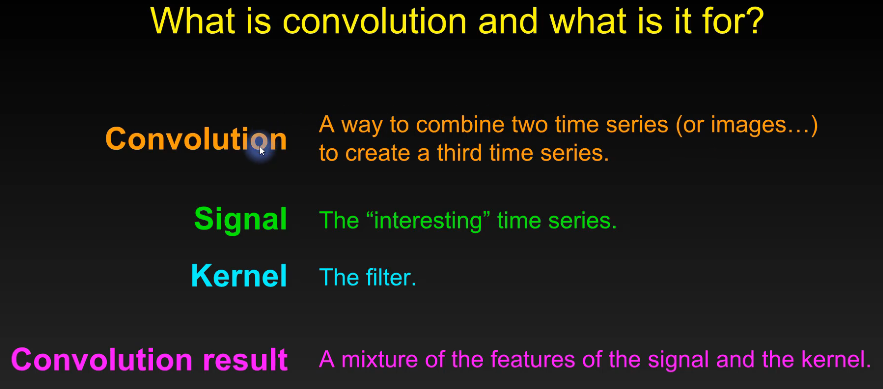

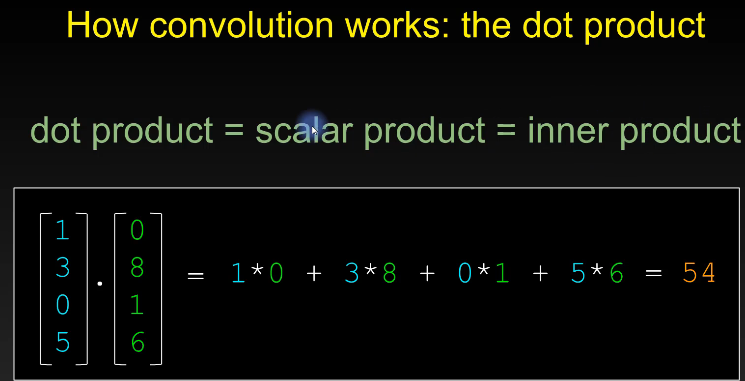

For calculation we pad signal with zeros. The result of calculation is at the center of the kernel, so it needs to have odd number.

The kernel is flipped before operation!!!

Length of conv result is =  lenght signal + len kernel -1

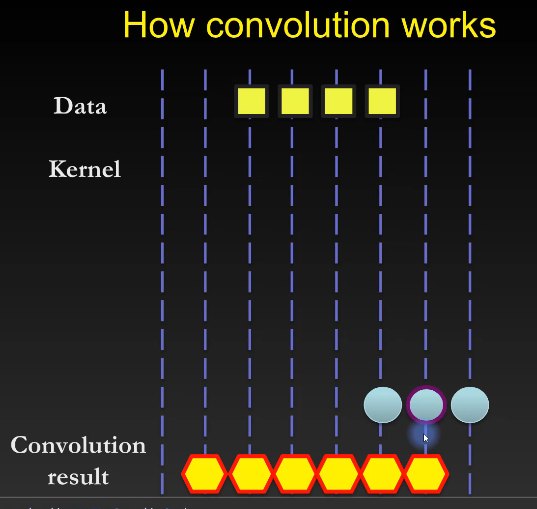

With the same argument you cut the left and right wings of the conv result that are introduced by the padding.

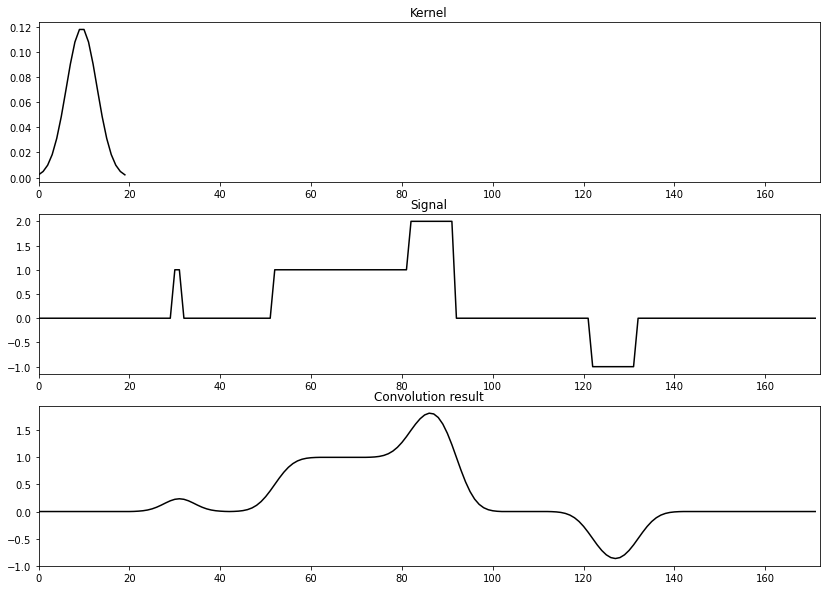

In [8]:
## first example to build intuition

signal1 = np.concatenate( (np.zeros(30),np.ones(2),np.zeros(20),np.ones(30),2*np.ones(10),np.zeros(30),-np.ones(10),np.zeros(40)) ,axis=0)
kernel  = np.exp( -np.linspace(-2,2,20)**2 )
kernel  = kernel/sum(kernel)
N = len(signal1)

plt.figure(figsize=(14,10))
plt.subplot(311)
plt.plot(kernel,'k')
plt.xlim([0,N])
plt.title('Kernel')

plt.subplot(312)
plt.plot(signal1,'k')
plt.xlim([0,N])
plt.title('Signal')

plt.subplot(313)
plt.plot( np.convolve(signal1,kernel,'same') ,'k')
plt.xlim([0,N])
plt.title('Convolution result')

plt.show()

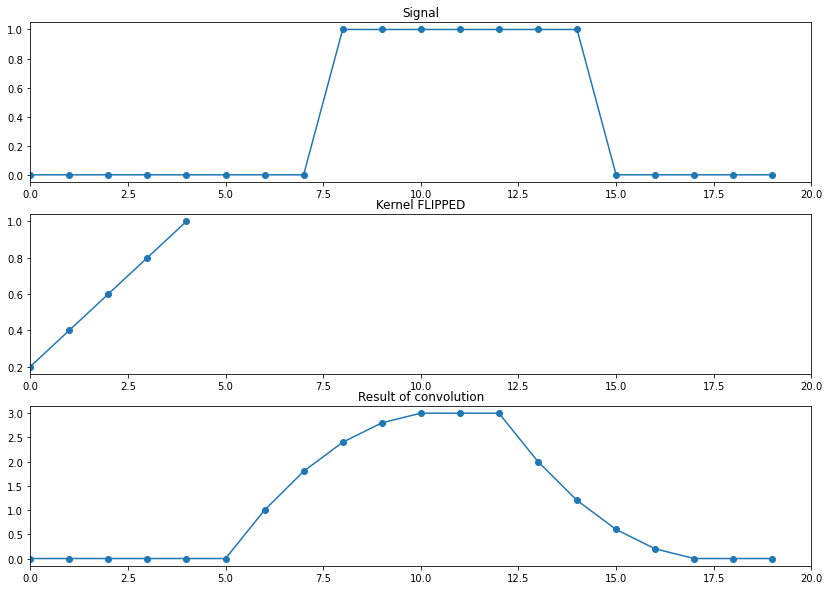

In [15]:
## in a bit more detail

# signal
signal1 = np.zeros(20)
signal1[8:15] = 1

# convolution kernel
kernel = [1,.8,.6,.4,.2]

# convolution sizes
nSign = len(signal1)
nKern = len(kernel)
nConv = nSign + nKern - 1


plt.figure(figsize=(14,10))
# plot the signal
plt.subplot(311)
plt.plot(signal1,'o-')
plt.xlim([0,nSign])
plt.title('Signal')

# plot the kernel
plt.subplot(312)
plt.plot(kernel[::-1],'o-')
plt.xlim([0,nSign])
plt.title('Kernel FLIPPED')


# plot the result of convolution
plt.subplot(313)
plt.plot(np.convolve(signal1,kernel,'same'),'o-')
plt.xlim([0,nSign])
plt.title('Result of convolution')
plt.show()

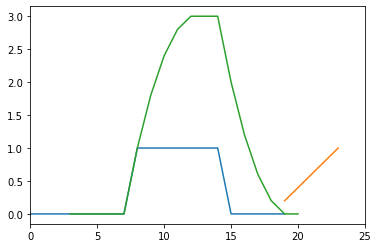

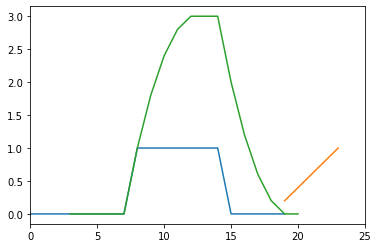

In [17]:
## convolution in animation

half_kern = int( np.floor(nKern/2) )

# flipped version of kernel
kflip = kernel[::-1] #-np.mean(kernel)

# zero-padded data for convolution
dat4conv = np.concatenate( (np.zeros(half_kern),signal1,np.zeros(half_kern)) ,axis=0)

# initialize convolution output
conv_res = np.zeros(nConv)


# run convolution
for ti in range(half_kern,nConv-half_kern):
    
    # get a chunk of data
    tempdata = dat4conv[ti-half_kern:ti+half_kern+1]
    
    # compute dot product (don't forget to flip the kernel backwards!)
    conv_res[ti] = np.sum( tempdata*kflip )
    
    # draw plot
    pl.cla() # clear the axis
    plt.plot(signal1)
    plt.plot(np.arange(ti-half_kern,ti+half_kern+1),kflip)
    plt.plot(np.arange(half_kern+1,ti),conv_res[half_kern+1:ti])
    plt.xlim([0,nConv+1])
    
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(.01)
    

# cut off edges
conv_res = conv_res[half_kern:-half_kern]


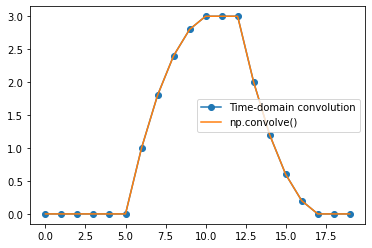

In [18]:
# compare "manual" and Python convolution result


py_conv = np.convolve(signal1,kernel,'same')


plt.plot(conv_res,'o-',label='Time-domain convolution')
plt.plot(py_conv,'-',label='np.convolve()')
plt.legend()
plt.show()

# Why is the kernal flipped

when its not flipped it's called cross-correlation!!

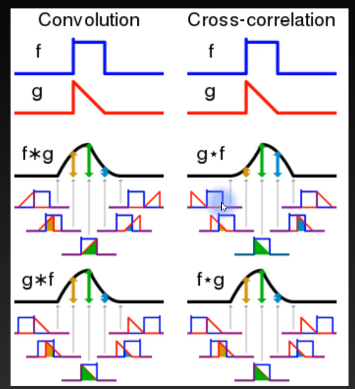

Mecanically the kernel is flipped because from the point of view of the signl you look to the left to the past. This is WEIIIIIRD!!
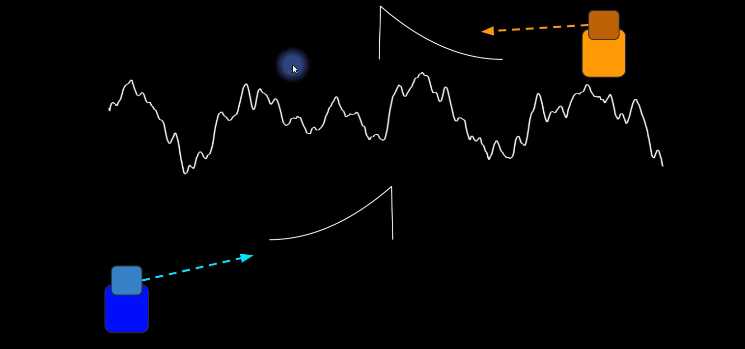


---
# VIDEO: The convolution theorem
---

If A is conv of signal then FFT.

If you FFT signal and kernel, then multiply them together you will get the same A.
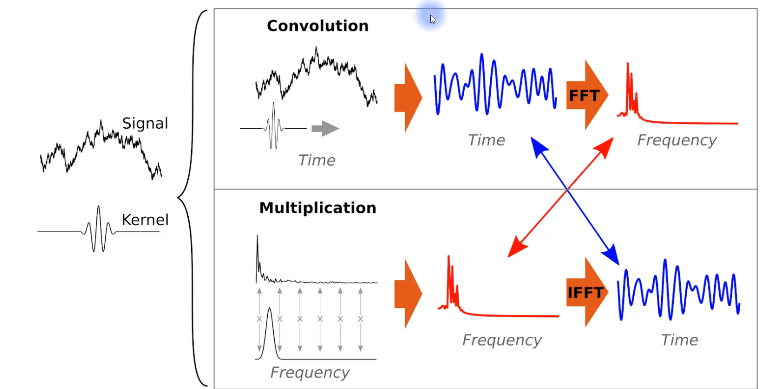

The advantage is that using FFT is actually faster than the conv operation.

In [32]:
## generate signal and kernel

# signal
signal1 = np.zeros(20)
signal1[8:15] = 1

# convolution kernel
kernel = [1, .8, .6, .4, .2]

# convolution sizes
nSign = len(signal1)
nKern = len(kernel)
nConv = nSign + nKern - 1
print(nConv)


24


In [26]:
## time-domain convolution

half_kern = int( np.floor(nKern/2) )

# flipped version of kernel
kflip = kernel[::-1]

# zero-padded data for convolution
dat4conv = np.concatenate( (np.zeros(half_kern),signal1,np.zeros(half_kern)) ,axis=0)

# initialize convolution output
conv_res = np.zeros(nConv)

# run convolution
for ti in range(half_kern,nConv-half_kern):
    
    # get a chunk of data
    tempdata = dat4conv[ti-half_kern:ti+half_kern+1]
    
    # compute dot product (don't forget to flip the kernel backwards!)
    conv_res[ti] = np.sum( tempdata*kflip )

# cut off edges
conv_res = conv_res[half_kern+1:-half_kern]


In [35]:
## convolution implemented in the frequency domain
print(len(signal1), len(kernel))
# spectra of signal and kernel
signalX = scipy.fftpack.fft(signal1,nConv)
kernelX = scipy.fftpack.fft(kernel,nConv)
print(len(signalX), len(kernelX))

# element-wise multiply
sigXkern = signalX * kernelX

# inverse FFT to get back to the time domain
conv_resFFT = np.real( scipy.fftpack.ifft( sigXkern ) )

# cut off edges
conv_resFFT = conv_resFFT[half_kern+1:-half_kern]


20 5
24 24


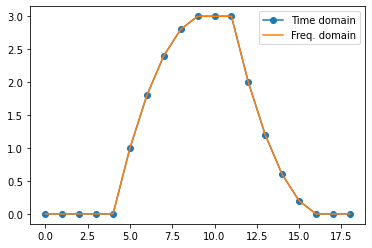

In [28]:
## plot for comparison

plt.plot(conv_res,'o-',label='Time domain')
plt.plot(conv_resFFT,'-',label='Freq. domain')
plt.legend()
plt.show()

# Think about conv as spectral multiplication

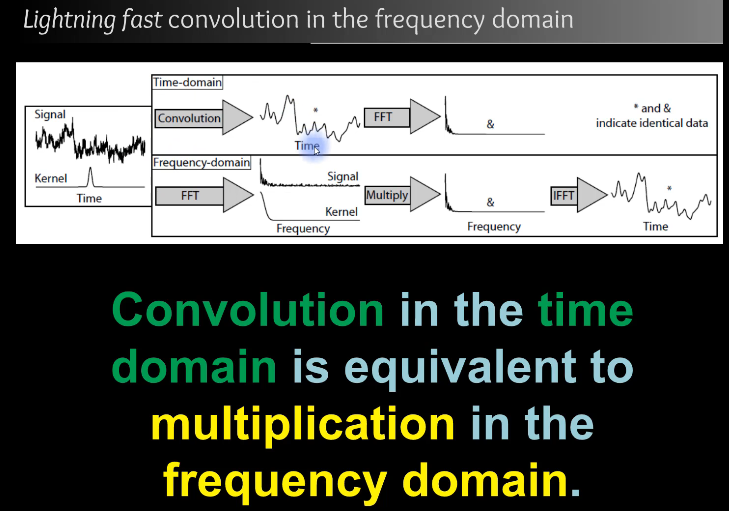

Why it is easier sometimes to think about conv in the freq domain:

On this example why the result of conv in the right figure is zero signal

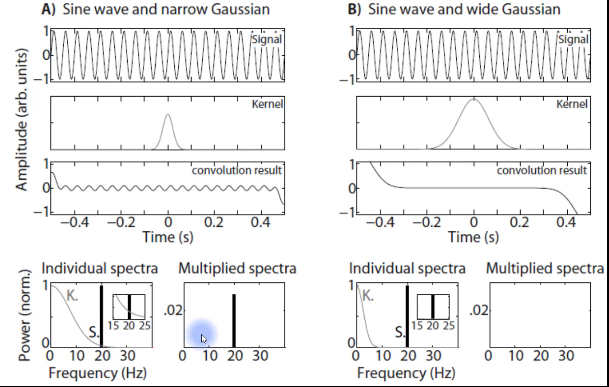

Example of the MORLET wavelet filter:

It result in a narrow band filter

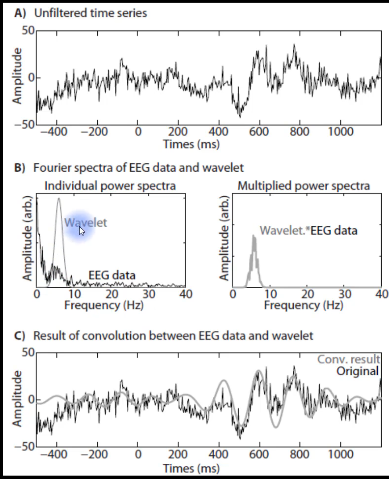

Gaussian filter result in low pass filter.


---
# VIDEO: Convolution with time-domain Gaussian (smoothing filter)
---


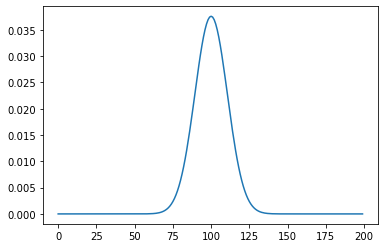

In [8]:
# simulation parameters
srate = 1000 # Hz
time  = np.arange(0,3,1/srate)
n     = len(time)
p     = 15 # poles for random interpolation


## create signal
# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl    = np.interp(np.linspace(0,p,n),np.arange(0,p),np.random.rand(p)*30)
noise   = noiseamp * np.random.randn(n)
signal1 = ampl + noise

# subtract mean to eliminate DC
signal1 = signal1 - np.mean(signal1)


## create the Gaussian kernel
# full-width half-maximum: the key Gaussian parameter
fwhm = 25 # in ms

# normalized time vector in ms
k = 100
gtime = 1000*np.arange(-k,k)/srate

# create Gaussian window
gauswin = np.exp( -(4*np.log(2)*gtime**2) / fwhm**2 )

# then normalize Gaussian to unit energy
gauswin = gauswin / np.sum(gauswin)


plt.plot(gauswin)

In [9]:
### filter as time-domain convolution

# initialize filtered signal vector
filtsigG = copy.deepcopy(signal1)

# implement the running mean filter
for i in range(k+1,n-k-1):
    # each point is the weighted average of k surrounding points
    filtsigG[i] = np.sum( signal1[i-k:i+k]*gauswin )



## now repeat in the frequency domain

# compute N's
nConv = n + 2*k+1 - 1 #(2*k+1) is len(kernel

# FFTs
dataX = scipy.fftpack.fft(signal1,nConv)
gausX = scipy.fftpack.fft(gauswin,nConv)

# IFFT
convres = np.real( scipy.fftpack.ifft( dataX*gausX ) )

# cut wings
convres = convres[k:-k]

# frequencies vector
hz = np.linspace(0,srate,nConv)

print(nConv)

3200


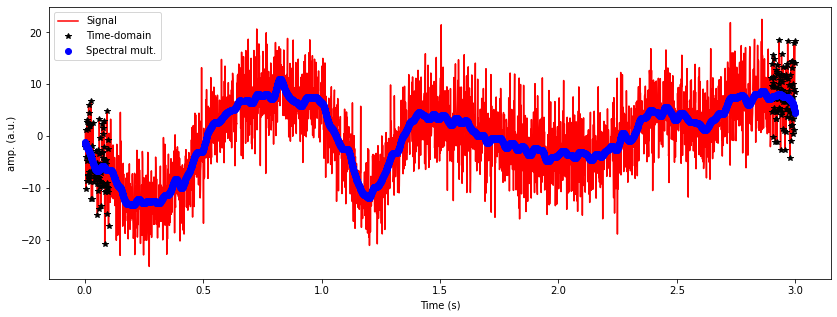

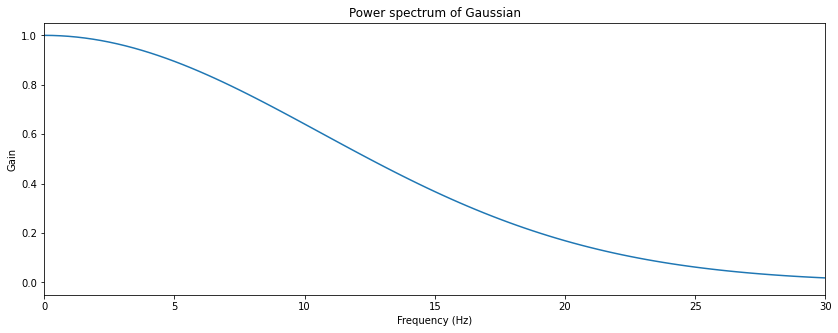

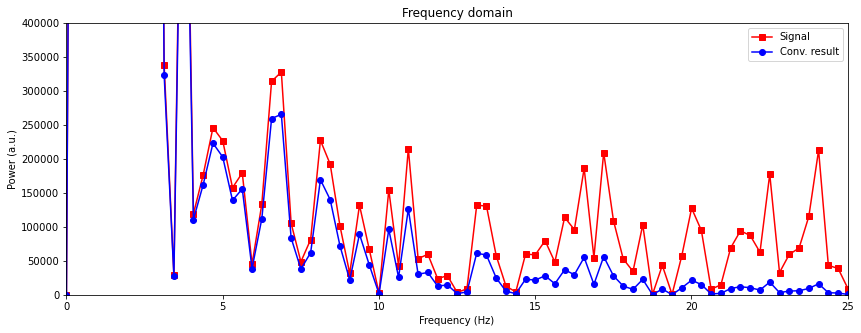

In [7]:
### time-domain plot

plt.figure(figsize=(14,5))
# lines
plt.plot(time,signal1,'r',label='Signal')
plt.plot(time,filtsigG,'k*',label='Time-domain')
plt.plot(time,convres,'bo',label='Spectral mult.')
plt.xlabel('Time (s)')
plt.ylabel('amp. (a.u.)')
plt.legend()
plt.show()




### frequency-domain plot

# plot Gaussian kernel
plt.figure(figsize=(14,5))
plt.plot(hz,np.abs(gausX)**2)
plt.xlim([0,30])
plt.ylabel('Gain'), plt.xlabel('Frequency (Hz)')
plt.title('Power spectrum of Gaussian')
plt.show()


# raw and filtered data spectra
plt.figure(figsize=(14,5))
plt.plot(hz,np.abs(dataX)**2,'rs-',label='Signal')
plt.plot(hz,np.abs(dataX*gausX)**2,'bo-',label='Conv. result')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power (a.u.)')
plt.legend()
plt.title('Frequency domain')
plt.xlim([0,25])
plt.ylim([0,400000])
plt.show()


---
# VIDEO: Convolution with frequency-domain Gaussian (narrowband filter)
---


Here the kernel is already in Freq domain so can multiply direectly to the freq signal

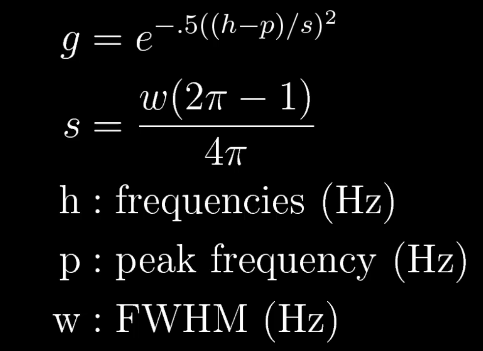

In [26]:
## create signal
srate = 1000 # Hz
time  = np.arange(0,3,1/srate)
n     = len(time)
p     = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl   = np.interp(np.linspace(0,p,n),np.arange(0,p),np.random.rand(p)*30)
noise  = noiseamp * np.random.randn(n)
signal1= ampl + noise

# subtract mean to eliminate DC
signal1 = signal1 - np.mean(signal1)


## create Gaussian spectral shape
# Gaussian parameters (in Hz)
peakf = 11 # frq 3 would be better at smoothing.
fwhm  = 5.2

# vector of frequencies
hz = np.linspace(0,srate,n)

# frequency-domain Gaussian
s  = fwhm*(2*np.pi-1)/(4*np.pi)  # normalized width
x  = hz-peakf              # shifted frequencies
fx = np.exp(-.5*(x/s)**2)     # gaussian


Text(0.5, 1.0, 'kernel in time domain')

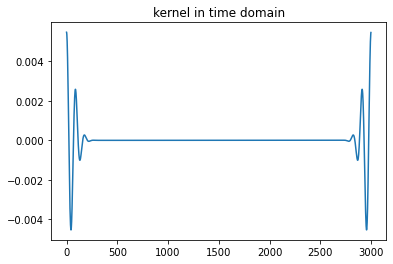

In [27]:
plt.plot(np.real( scipy.fftpack.ifft(fx)))
plt.title("kernel in time domain")

In [28]:
## now for convolution

# FFTs
dataX = scipy.fftpack.fft(signal1)

# IFFT
convres = 2*np.real( scipy.fftpack.ifft( dataX*fx ))

# frequencies vector
hz = np.linspace(0,srate,n)


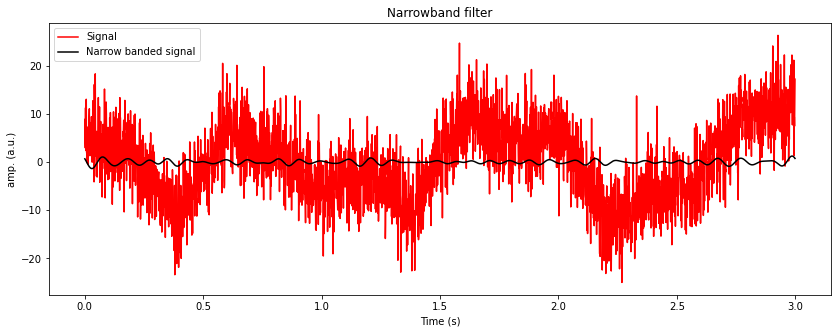

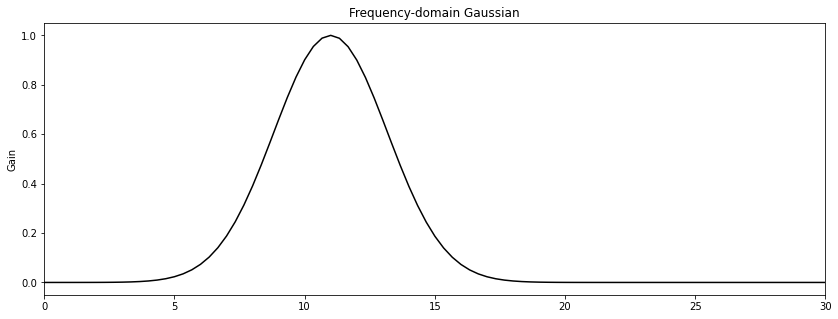

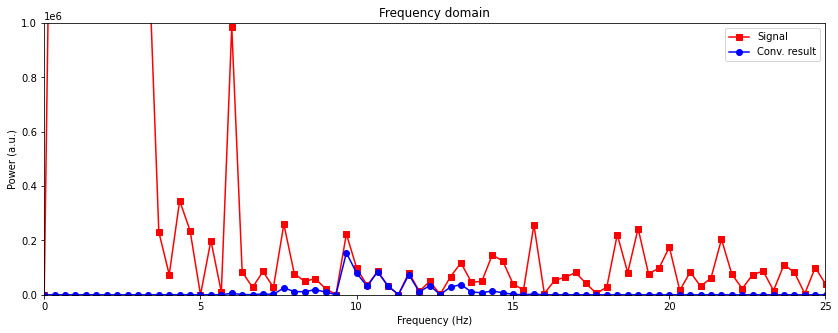

In [29]:
### time-domain plot

# lines
plt.figure(figsize=(14,5))
plt.plot(time,signal1,'r',label='Signal')
plt.plot(time,convres,'k',label='Narrow banded signal')
plt.xlabel('Time (s)'), plt.ylabel('amp. (a.u.)')
plt.legend()
plt.title('Narrowband filter')
plt.show()



### frequency-domain plot

# plot Gaussian kernel
plt.figure(figsize=(14,5))
plt.plot(hz,fx,'k')
plt.xlim([0,30])
plt.ylabel('Gain')
plt.title('Frequency-domain Gaussian')
plt.show()

# raw and filtered data spectra
plt.figure(figsize=(14,5))
plt.plot(hz,np.abs(dataX)**2,'rs-',label='Signal')
plt.plot(hz,np.abs(dataX*fx)**2,'bo-',label='Conv. result')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power (a.u.)')
plt.legend()
plt.title('Frequency domain')
plt.xlim([0,25])
plt.ylim([0,1e6])
plt.show()


---
# VIDEO: Convolution with Planck taper (bandpass filter)
---


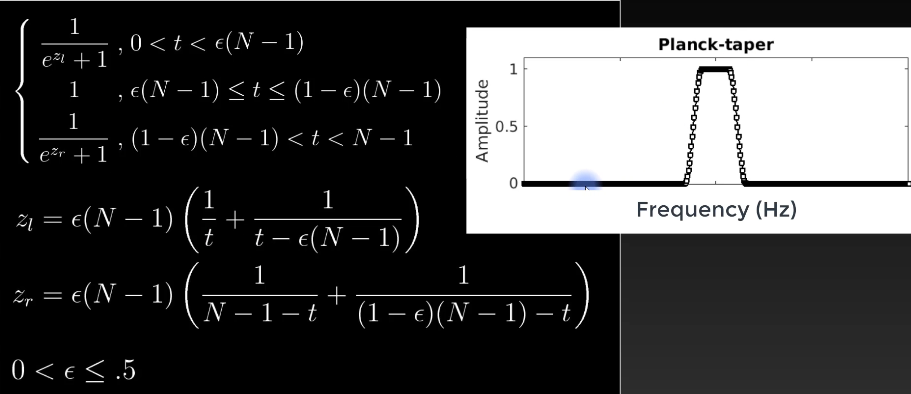

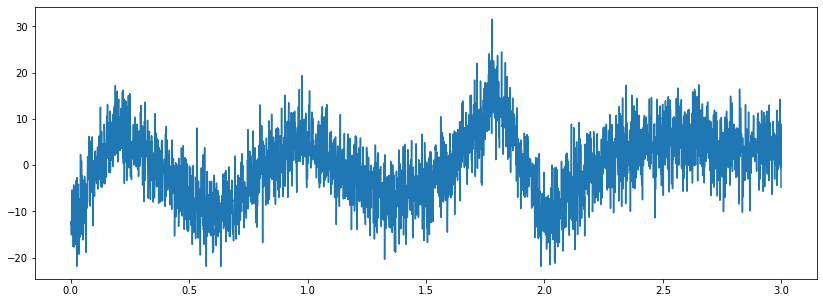

In [30]:
## create the signal

srate = 1000 # Hz
time  = np.arange(0,3,1/srate)
n     = len(time)
p     = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl   = np.interp(np.linspace(0,p,n),np.arange(0,p),np.random.rand(p)*30)
noise  = noiseamp * np.random.randn(n)
signal1= ampl + noise

# subtract mean to eliminate DC
signal1 = signal1 - np.mean(signal1)

plt.figure(figsize=(14,5))
plt.plot(time,signal1)
plt.show()

In [31]:
## create Planck spectral shape

# frequencies
hz = np.linspace(0,srate,n)

# edge decay, must be between 0 and .5
eta = .15

# spectral parameters
fwhm  = 13  # half width
peakf = 20  # freq center

# convert fwhm to indices
mp = np.round( 2*fwhm*n/srate ) # in MATLAB this is np, but np=numpy
pt = np.arange(1,mp+1)

# find center point index
fidx = np.argmin( (hz-peakf)**2 )


# define left and right exponentials
Zl = eta*(mp-1) * ( 1/pt + 1/(pt-eta*(mp-1)) )
Zr = eta*(mp-1) * ( 1/(mp-1-pt) + 1/( (1-eta)*(mp-1)-pt ) )

# create the taper
offset = mp%2
bounds = [ np.floor(eta*(mp-1))-offset , np.ceil((1-eta)*(mp-(1-offset))) ]
plancktaper = np.concatenate( (1/(np.exp(Zl[range(0,int(bounds[0]))])+1) ,np.ones(int(np.diff(bounds)+1)), 1/(np.exp(Zr[range(int(bounds[1]),len(Zr)-1)])+1)) ,axis=0)

# put the taper inside zeros
px = np.zeros( len(hz) )
pidx = range( int(np.max((0,fidx-np.floor(mp/2)+1))) , int(fidx+np.floor(mp/2)-mp%2+1) )
px[np.round(pidx)] = plancktaper


C:\Users\fabrice.lacout\AppData\Local\Temp\ipykernel_13568\1368980740.py:23: RuntimeWarning: divide by zero encountered in true_divide
  Zr = eta*(mp-1) * ( 1/(mp-1-pt) + 1/( (1-eta)*(mp-1)-pt ) )


In [32]:
## now for convolution

# FFTs
dataX = scipy.fftpack.fft(signal1)

# IFFT
convres = 2*np.real( scipy.fftpack.ifft( dataX*px ))

# frequencies vector
hz = np.linspace(0,srate,n)


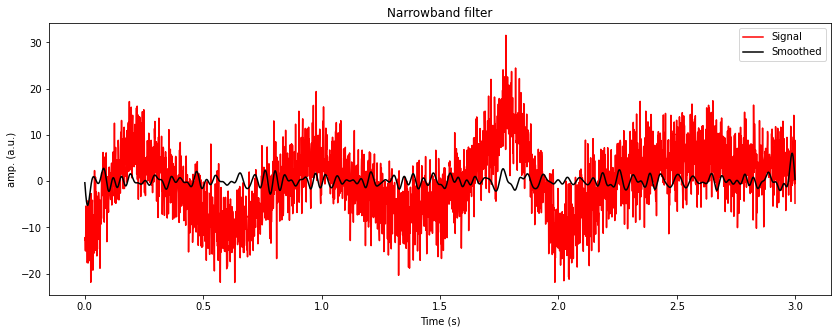

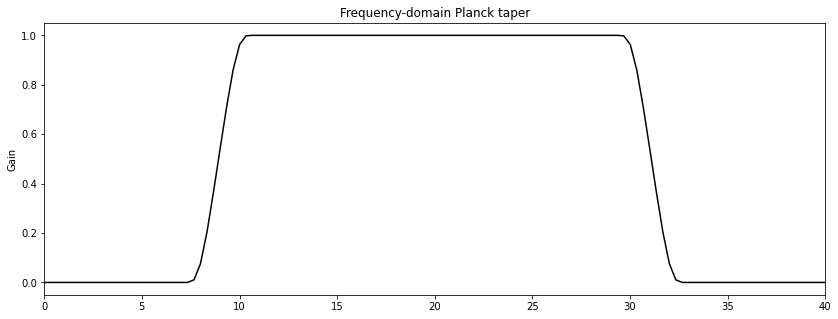

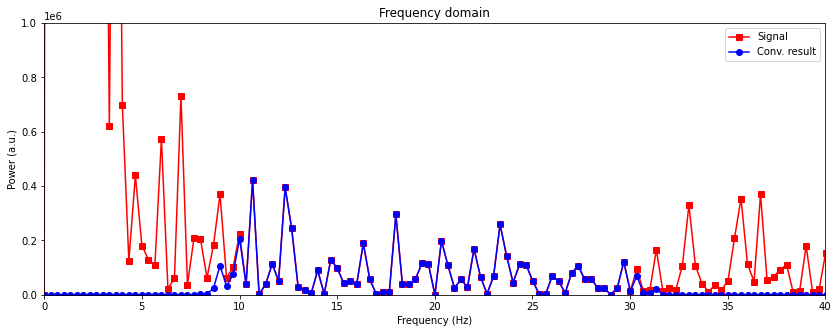

In [33]:
### time-domain plots

# lines
plt.figure(figsize=(14,5))
plt.plot(time,signal1,'r',label='Signal')
plt.plot(time,convres,'k',label='Smoothed')
plt.xlabel('Time (s)'), plt.ylabel('amp. (a.u.)')
plt.legend()
plt.title('Narrowband filter')
plt.show()


### frequency-domain plot

# plot Gaussian kernel
plt.figure(figsize=(14,5))
plt.plot(hz,px,'k')
plt.xlim([0,peakf*2])
plt.ylabel('Gain')
plt.title('Frequency-domain Planck taper')
plt.show()

# raw and filtered data spectra
plt.figure(figsize=(14,5))
plt.plot(hz,np.abs(dataX)**2,'rs-',label='Signal')
plt.plot(hz,np.abs(dataX*px)**2,'bo-',label='Conv. result')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power (a.u.)')
plt.legend()
plt.title('Frequency domain')
plt.xlim([0,peakf*2])
plt.ylim([0,1e6])
plt.show()

# Code Challenge

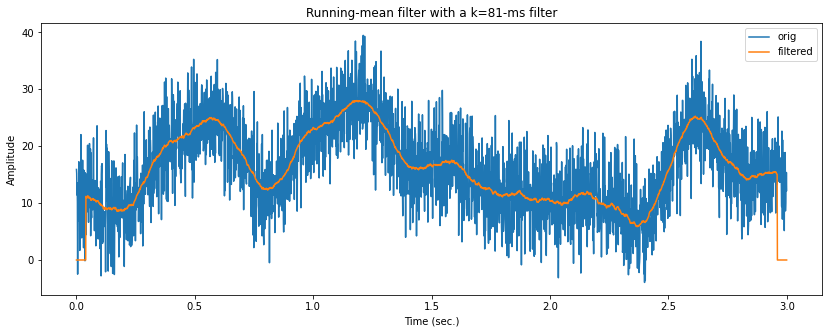

In [34]:
# create signal
srate = 1000 # Hz
time  = np.arange(0,3,1/srate) # shape:3000
n     = len(time)
p     = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
# np.interp(new_x, x, y)
ampl   = np.interp(np.linspace(0,p,n), np.arange(0,p), np.random.rand(p)*30) # generate Y values.
noise  = noiseamp * np.random.randn(n)
signal = ampl + noise

# initialize filtered signal vector
filtsig = np.zeros(n)  #  filtsig = signal.copy() to have edges not at zero

# implement the running mean filter
k = 40 # filter window is actually k*2+1
for i in range(k,n-k):
    # each point is the average of k surrounding points
    filtsig[i] = np.mean(signal[i-k:i+k+1])

# compute window size in ms
windowsize = 1000*(k*2+1) / srate


# plot the noisy and filtered signals
plt.figure(figsize=(14,5))
plt.plot(time,signal,label='orig')
plt.plot(time,filtsig,label='filtered')
plt.legend()
plt.xlabel('Time (sec.)')
plt.ylabel('Amplitude')
plt.title('Running-mean filter with a k=%d-ms filter' %windowsize)

plt.show()

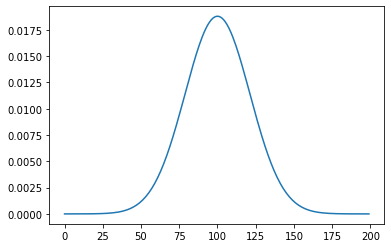

In [35]:
## create the Gaussian kernel
# full-width half-maximum: the key Gaussian parameter
fwhm = 50 # in ms

# normalized time vector in ms
k = 100
gtime = 1000*np.arange(-k,k)/srate

# create Gaussian window
gauswin = np.exp( -(4*np.log(2)*gtime**2) / fwhm**2 )

# then normalize Gaussian to unit energy
gauswin = gauswin / np.sum(gauswin)


plt.plot(gauswin)

In [38]:
# compute N's
nConv = n + 2*k+1 - 1 #(2*k+1) is len(kernel

# FFTs
dataX = scipy.fftpack.fft(signal,nConv)
gausX = scipy.fftpack.fft(gauswin,nConv)

# IFFT
convres = np.real( scipy.fftpack.ifft( dataX*gausX ) )

# cut wings
convres = convres[k:-k]

# frequencies vector
hz = np.linspace(0,srate,nConv)

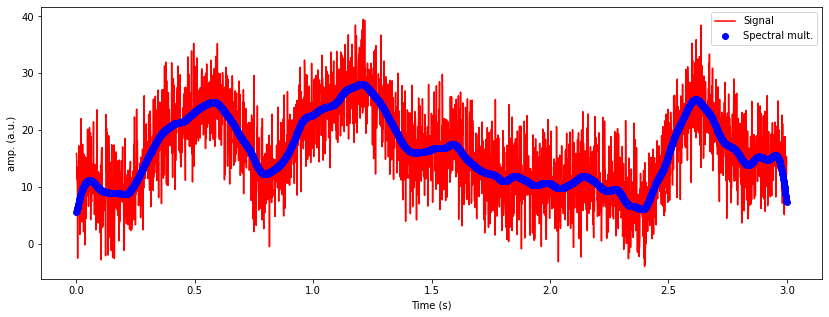

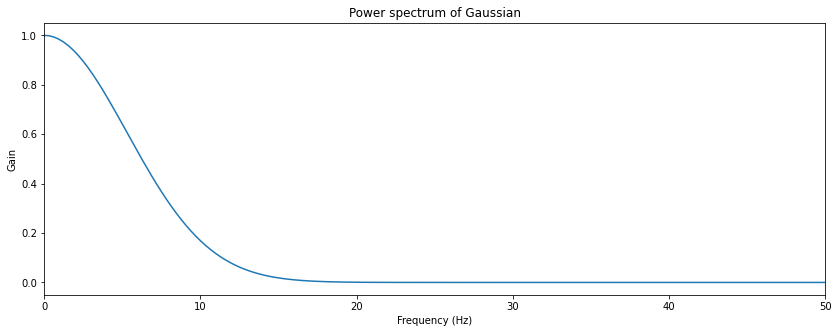

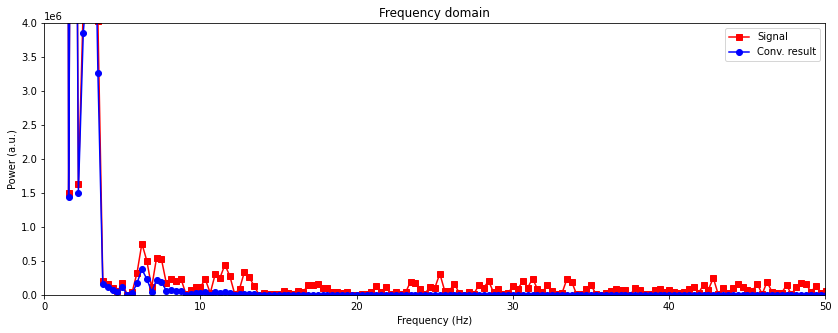

In [39]:
### time-domain plot

plt.figure(figsize=(14,5))
# lines
plt.plot(time,signal,'r',label='Signal')
plt.plot(time,convres,'bo',label='Spectral mult.')
plt.xlabel('Time (s)')
plt.ylabel('amp. (a.u.)')
plt.legend()
plt.show()




### frequency-domain plot

# plot Gaussian kernel
plt.figure(figsize=(14,5))
plt.plot(hz,np.abs(gausX)**2)
plt.xlim([0,50])
plt.ylabel('Gain'), plt.xlabel('Frequency (Hz)')
plt.title('Power spectrum of Gaussian')
plt.show()


# raw and filtered data spectra
plt.figure(figsize=(14,5))
plt.plot(hz,np.abs(dataX)**2,'rs-',label='Signal')
plt.plot(hz,np.abs(dataX*gausX)**2,'bo-',label='Conv. result')
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power (a.u.)')
plt.legend()
plt.title('Frequency domain')
plt.xlim([0,50])
plt.ylim([0,4000000])
plt.show()